In [1]:
import numpy as np
import tensorflow as tf
import matplotlib
import observations
import gpflow
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn
seaborn.set(style="white")

matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.bottom'] = False
matplotlib.rcParams['axes.spines.left'] = False
font = {'family' : 'Ubuntu, Arial',
        'size'   : 16}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=16)
matplotlib.rc('ytick', labelsize=16)
matplotlib.rc('figure', figsize=(11, 6.8))
matplotlib.rc('axes', titlesize=22)
matplotlib.rc('legend', fontsize=16)
matplotlib.rc('axes', labelsize=16)

assert gpflow.settings.float_type == np.float64

import os, sys
current_dir = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.insert(0, current_dir)
sys.path.insert(0, os.path.join(current_dir, 'conv_gp/'))
from conv_gp.main import build_deep_model
from argparse import Namespace

settings = gpflow.settings

In [2]:
def default_flags(**kwargs):
    flags = {
        'M': 64,
        'random_inducing': False,
        'batch_size': 128 
    }
    for key, value in kwargs.items():
        flags[key] = value
    return Namespace(**flags)

flags = default_flags()
(X_train, Y_train), (X_test, Y_test) = observations.mnist('/tmp/mnist')
from sklearn import preprocessing

X_transform = preprocessing.StandardScaler()
X_train = X_transform.fit_transform(X_train).astype(gpflow.settings.float_type)
X_test = X_transform.transform(X_test).astype(gpflow.settings.float_type)
Y_train, Y_test = Y_train.reshape(-1, 1), Y_test.reshape(-1, 1)

In [3]:
model = build_deep_model(flags, X_train, Y_train)

z initialized


In [4]:
optimizer = gpflow.training.GradientDescentOptimizer(learning_rate=1e-4)
optimize = optimizer.make_optimize_action(model)
sess = model.enquire_session()

elbos = []
Z_gradients = []
q_sqrt_gradients = []
E_log_p_Ys = []
KLs = []

E_Z_gradients = []
E_q_sqrt_gradients = []
KL_q_sqrt_gradients = []
for i in range(10):
    print('Iteration: {}'.format(i), end='\r')
    optimize()
    elbo = sess.run(model.objective)
    elbos.append(elbo)
    
    Z_gradient = sess.run(tf.gradients(model.objective, model.layers[0].feature.Z.parameter_tensor))[0]
    q_gradient = sess.run(tf.gradients(model.objective, model.layers[0].q_sqrt.parameter_tensor))[0]
    Z_gradients.append(Z_gradient)
    q_sqrt_gradients.append(q_gradient)
    
    E_log_p_Y = tf.reduce_sum(model.E_log_p_Y(model.X.parameter_tensor, model.Y.parameter_tensor))
    
    with gpflow.params_as_tensors_for(model):
        KL = tf.reduce_sum([layer.KL() for layer in model.layers])
        scale = tf.cast(model.num_data, settings.float_type) / tf.cast(tf.shape(model.X)[0], settings.float_type)
        E_log_p_Y = scale * E_log_p_Y
        E_log_p_Ys.append(sess.run(E_log_p_Y))
        KLs.append(sess.run(KL))
    
        E_Z_grad = sess.run(tf.gradients([E_log_p_Y], [model.layers[0].feature.Z]))[0]
        E_Z_gradients.append(E_Z_grad)
        E_q_sqrt_grad = sess.run(tf.gradients([E_log_p_Y], [model.layers[0].q_sqrt]))[0]
        E_q_sqrt_gradients.append(E_q_sqrt_grad)

        KL_q_grad = sess.run(tf.gradients([KL], [model.layers[0].q_sqrt]))[0]
        KL_q_sqrt_gradients.append(KL_q_grad)
    

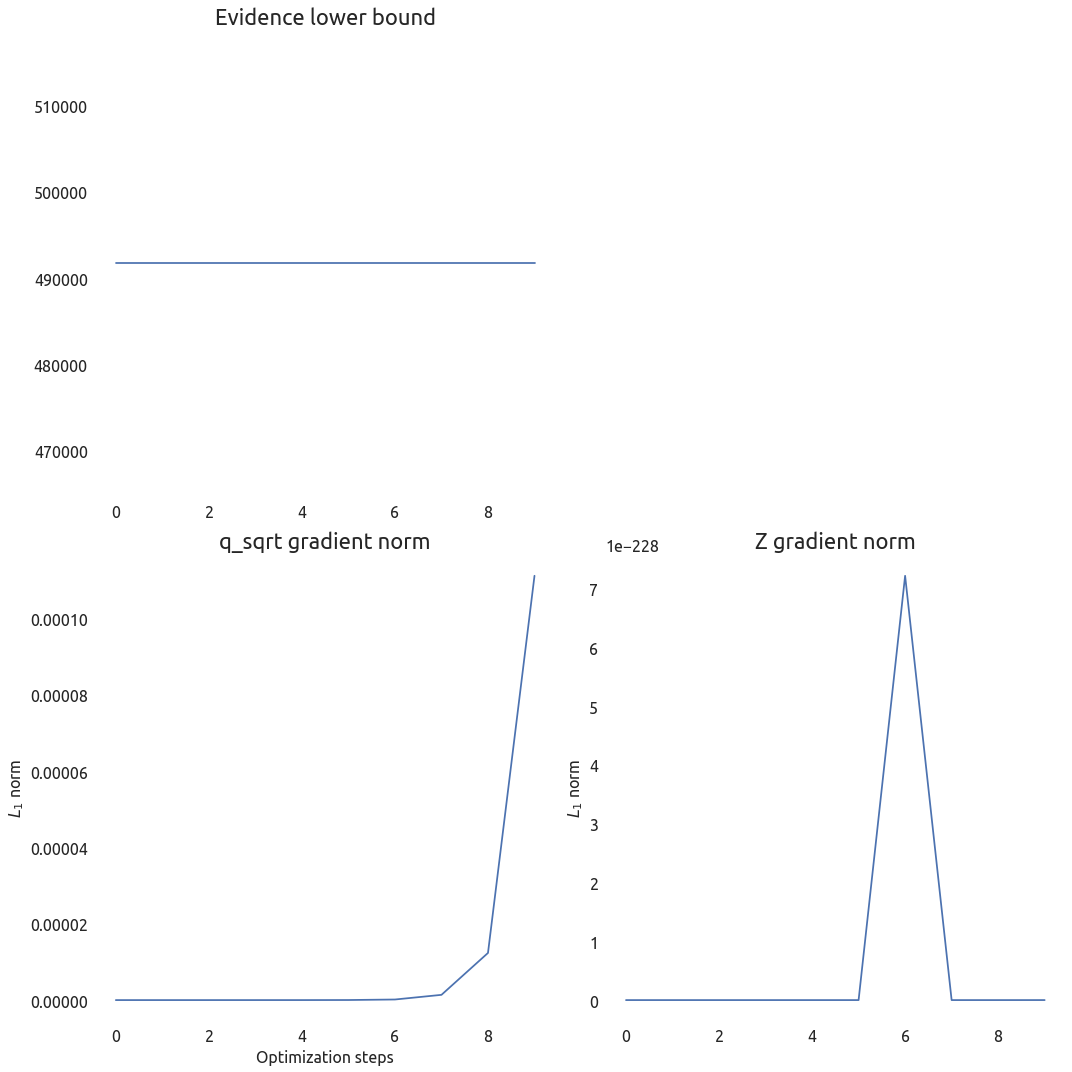

In [5]:
grad_norms = lambda gradients: np.stack([np.linalg.norm(g, ord=1) for g in gradients])
plt.figure(figsize=(15, 15))
axis2 = plt.subplot(223)

axis2.set_title('q_sqrt gradient norm')
axis2.set_ylabel("$L_1$ norm")
axis2.set_xlabel("Optimization steps")
axis2.plot(np.arange(len(q_sqrt_gradients)), grad_norms(q_sqrt_gradients))

axis1 = plt.subplot(224, sharex=axis2)

axis1.set_title("Z gradient norm")
axis1.set_ylabel("$L_1$ norm")
axis1.plot(np.arange(len(Z_gradients)), grad_norms(Z_gradients))


axis0 = plt.subplot(221, sharex=axis1)

axis0.set_title("Evidence lower bound")
axis0.plot(np.arange(len(elbos)), elbos)

plt.tight_layout()

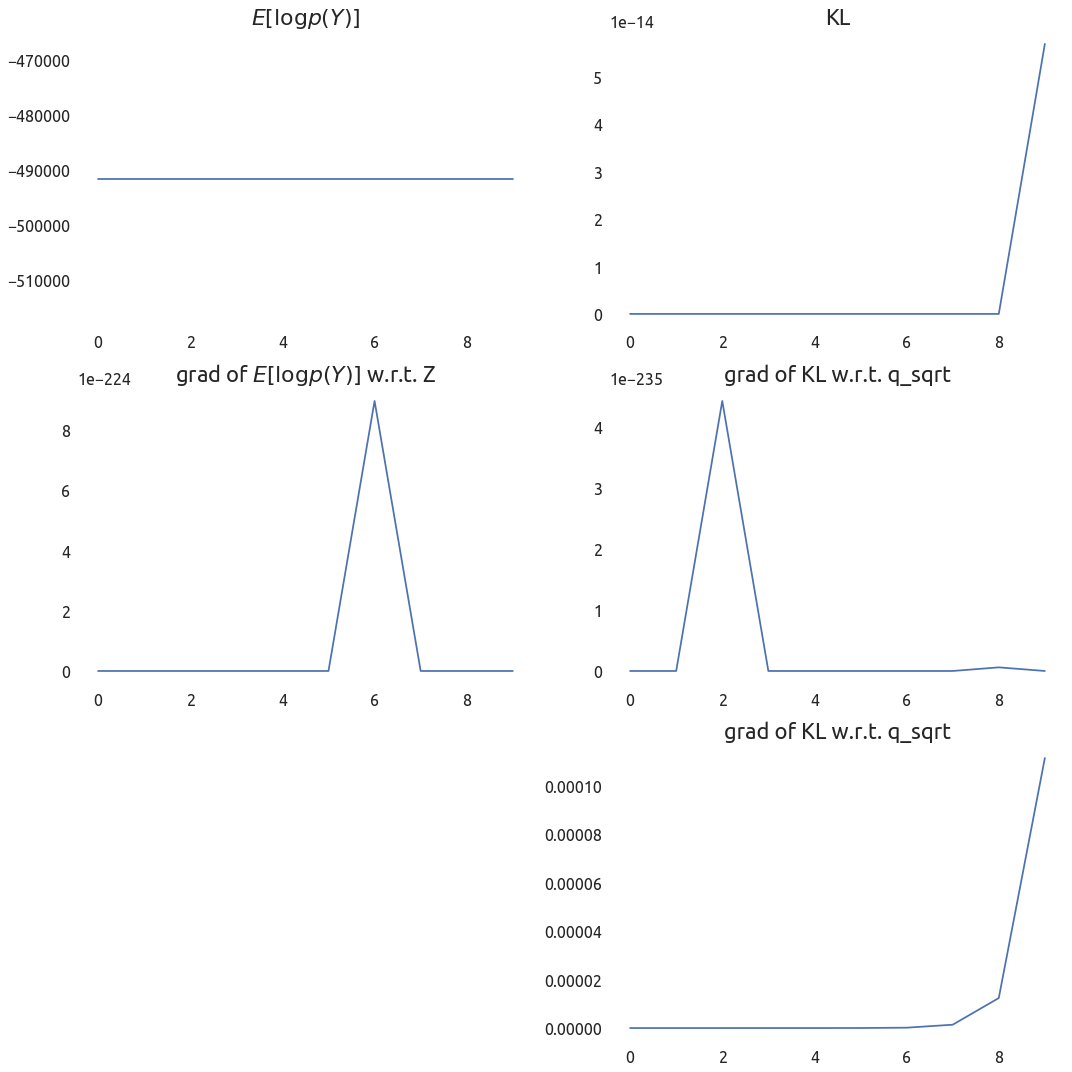

In [6]:
plt.figure(figsize=(15, 15))
axis = plt.subplot(321)
steps = np.arange(len(KLs))
axis.set_title("$E[\log{p(Y)}]$")
axis.plot(steps, E_log_p_Ys)

axis = plt.subplot(322)
axis.set_title("KL")
axis.plot(steps, KLs)

axis = plt.subplot(323)

axis.set_title("grad of $E[\log{p(Y)}]$ w.r.t. Z")
axis.plot(steps, grad_norms(E_Z_gradients))

axis = plt.subplot(324)

axis.set_title("grad of KL w.r.t. q_sqrt")
axis.plot(steps, grad_norms([g[0] for g in E_q_sqrt_gradients]))

axis = plt.subplot(326)

axis.set_title("grad of KL w.r.t. q_sqrt")
axis.plot(steps, grad_norms([g[0] for g in KL_q_sqrt_gradients]))


plt.tight_layout()

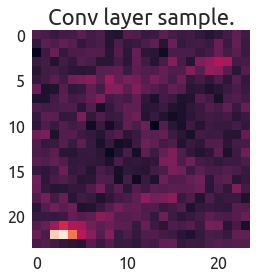

In [7]:
image = X_train[0]
Fs, Fmeans, Fvars = model.propagate(image[None])

F = sess.run(Fs[0])
plt.title("Conv layer sample.")
plt.imshow(F.reshape(24, 24));